# Homework 4
## Author: Siddhant Madan

### Import libraries

In [1]:
import warnings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

### Define required functions

Define functions to calculate return, volatility and maximum drawdown

In [3]:
def returns(prices):
    """
    Calculates the returns from the price series
    """
    return prices.pct_change()

In [4]:
def vol_ohlc(df, lookback=10):
    """
    Calculates the volatility from the ohlc dataframe
    """
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [5]:
def max_drawdown(prices):
    """
    Calculates the maximum drawdown from the price series
    """
    cum_max = prices.cummax()
    dd = (prices - cum_max) / cum_max
    max_dd = dd.cummin()
    return max_dd

### Set the parameters for the notebook

In [6]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///data/data.db'

In [7]:
# Parameters
from_date = "2021-11-29 00:00:00"
to_date = "2021-12-13 00:00:00"
token = "USDT"
connection_string = "sqlite:///data/data.db"


### Fetch the dataset

In [8]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

### Calculate the returns, volatility, and the maximum drawdown

In [9]:
prices['returns'] = returns(prices['close'])
prices['volatility'] = vol_ohlc(prices)
prices['max_drawdown'] = max_drawdown(prices['close'])

### Plot close prices, returns, volatility, and maximum drawdowns

In [10]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)


In [11]:
%%capture
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

Text(0.5, 0.98, 'Market action for USDT between 2021-11-29 00:00:00 and 2021-12-13 00:00:00')

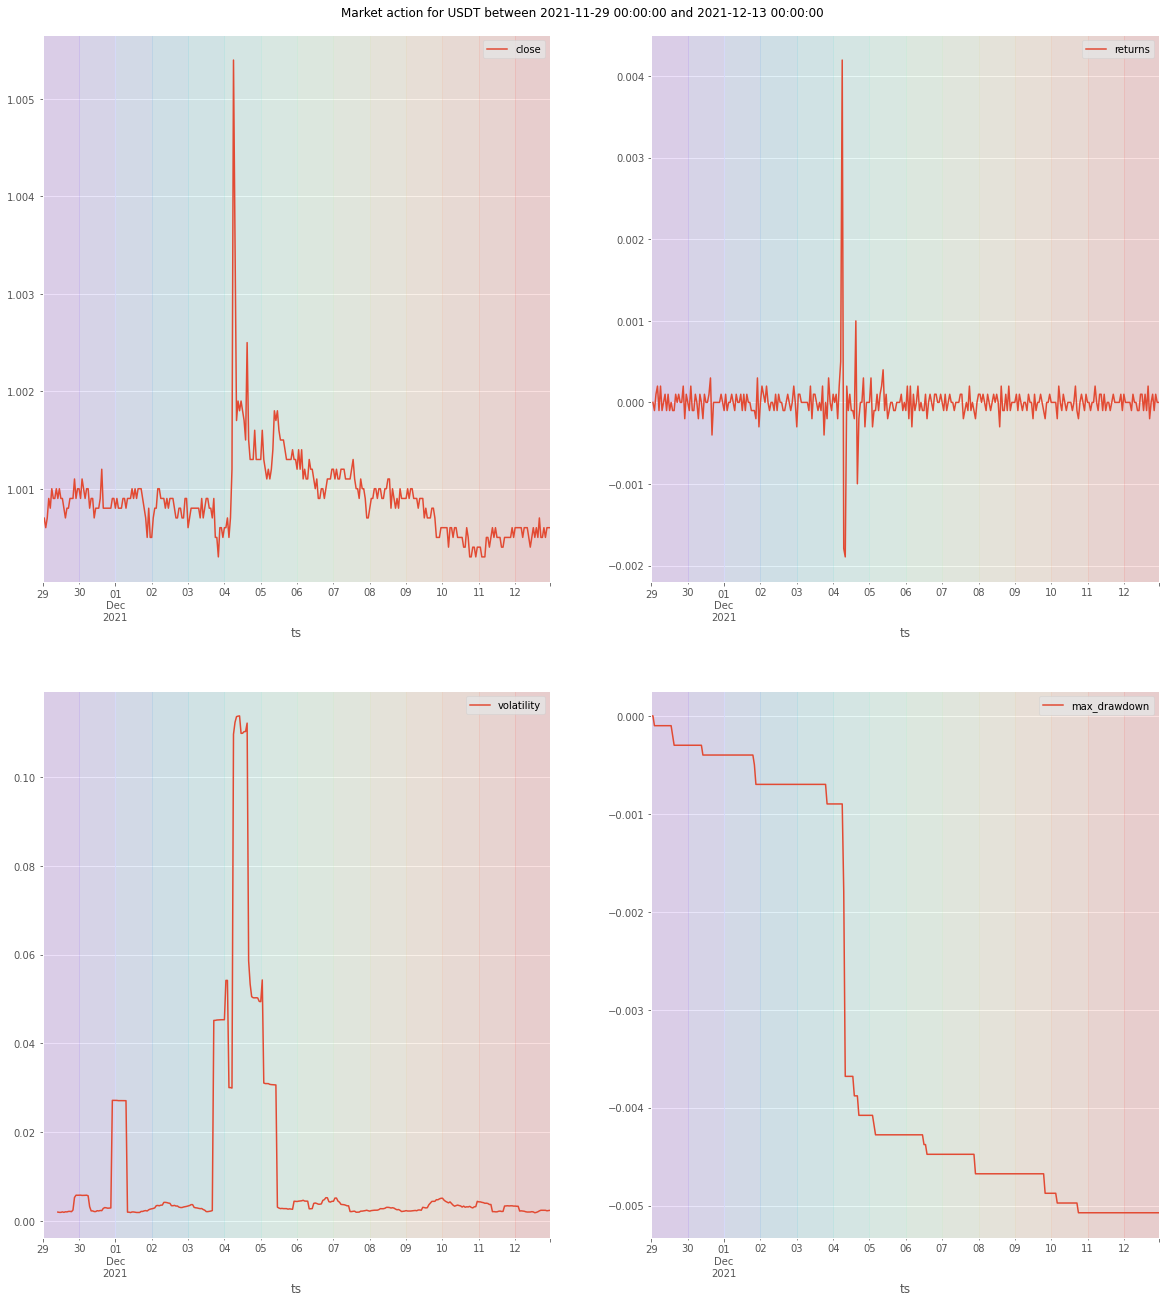

In [12]:
series_plot(prices[['close']], ax=ax[0, 0])
series_plot(prices[['returns']], ax=ax[0, 1])
series_plot(prices[['volatility']], ax=ax[1, 0])
series_plot(prices[['max_drawdown']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig.subplots_adjust(top=0.96)
fig

### Glue the relevant scraps to the notebook

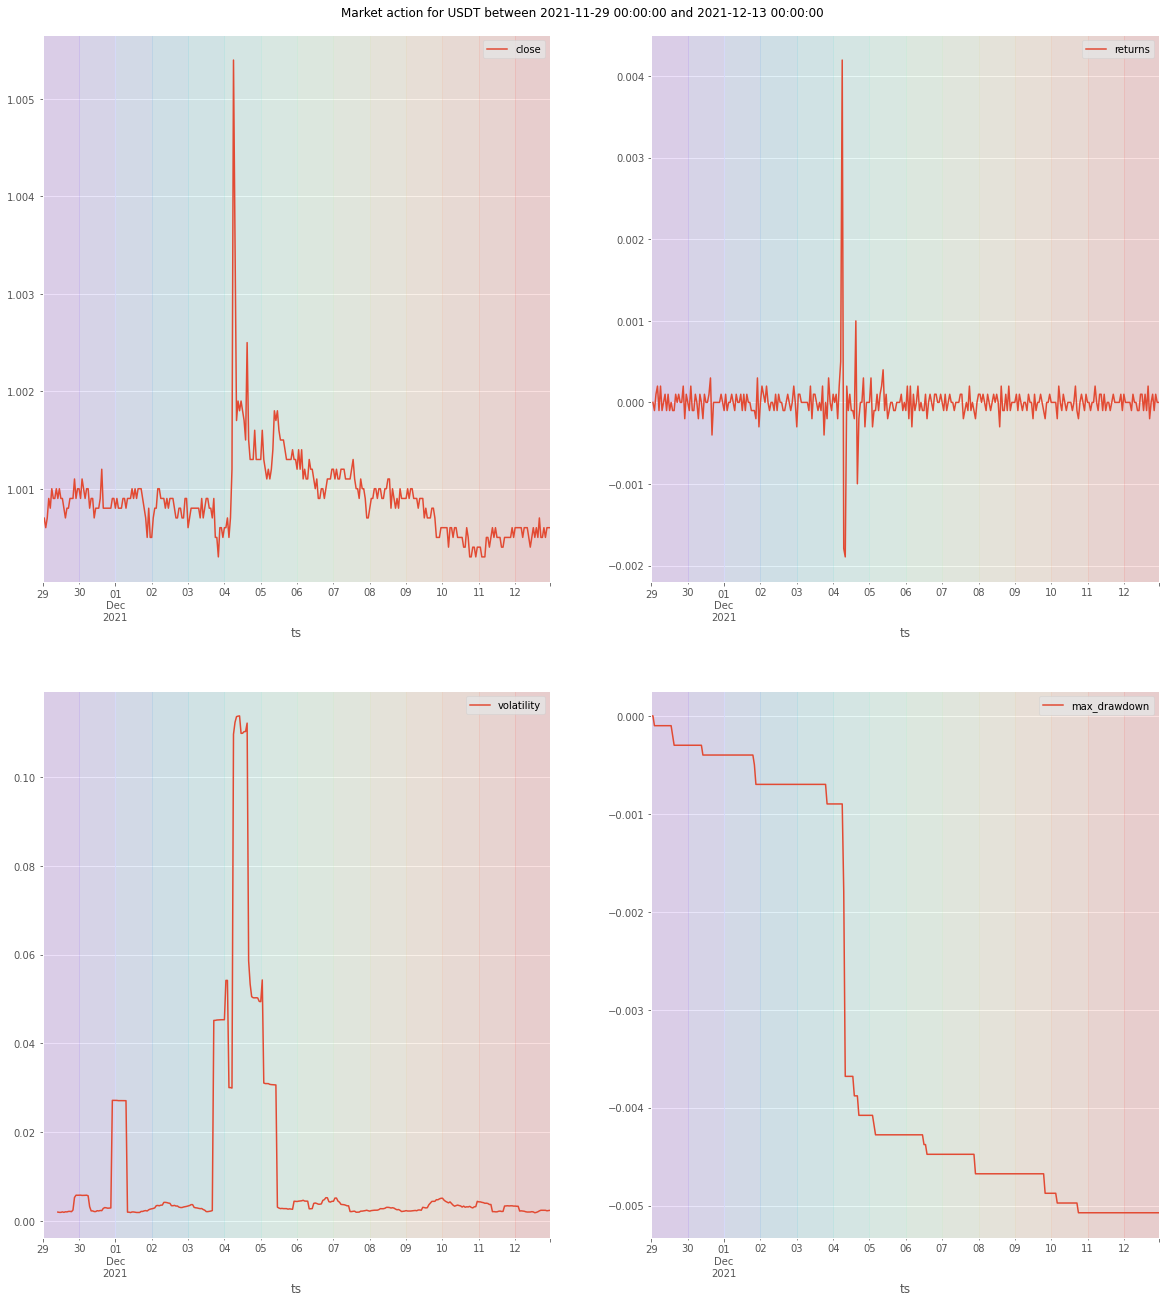

In [13]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)